# DRF Parameter Validation (Part 1)

In this notebook you are going to evaluate a DRF-based driving behaviour model to control the SDV with a protocol named *close-loop* evaluation in an assigned Lyft scene.


## What is close-loop and open-loop evaluation?
In close-loop evaluation, the SDV is completely controlled by our customized model throughout a scene. In each scene, the SDV should make ~250 predictions regarding its future position.

Whereas in open-loop evaluation we evaluate our model prediction as we follow the annotated ground truth. In each frame, we compare the predictions of our model against the annotated ground truth.

<!-- **Regardless of the metric used, this evaluation protocol doesn't modify the future locations according to our predictions.**

![open-loop](../../docs/images/planning/open-loop.svg) -->


## What can we use close-loop evaluation for?
Closed-loop is crucial to asses a model's capabilities before deploying it in the real world. Ideally, we would test the model on the road in the real world. However, this is clearly very expensive and scales poorly. Forward-simulation is an attempt to evaluate the system in a setting which is as close as possible to a real road test on the same route.

Differently from open-loop, the model is in full control of the SDV and predictions are used to compute the future location of the SDV.


## Is close-loop evaluation enough?
Closed-loop evaluation is an important step forward towards evaluating how our policy would perform on the road. However, it still has some limitations.

The critical one is the non-reactivity of other traffic participants. In fact, while the SDV is now controlled by our policy, other actors are still being replayed from the original log. In this setting, a chasing car will not slow down if our policy choses a different speed profile for the SDV, resulting in a rear collision that wouldn't obviously occur in the real world.

For this reason, closed-loop evaluation is only accurate for the first few seconds of forward simulation. This can be mitigated when enough data exists for the task.

This DRF-based driver behaviour model is designed to serve as the reactive traffic agents in future simulations. This notebook demonstrate how we validate its capability with the Lyft prediction dataset.

## Imports & packages

In [1]:
## from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
#from l5kit.dataset import EgoDataset
#from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points, angular_distance, transform_point
from l5kit.visualization import TARGET_POINTS_COLOR, PREDICTED_POINTS_COLOR, draw_trajectory
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

from Param_Estimation.map.map_builder import MapBuilder
from Param_Estimation.driver.DRFModel import DRFModel
from Param_Estimation.map.rasterizer_builder import build_rasterizer
from Param_Estimation.dataset.ego import EgoDataset

import os

D:\YURUIDU\DRF_Simulation\Param_Estimation\venv\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(
d:\yuruidu\drf_simulation\param_estimation\Param_Estimation\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "."
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

## Load the evaluation data
**we don't change our data here**.

When performing evaluation we're interested in knowing the performance on the annotated data.

In [3]:
# ===== INIT DATASET
eval_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
eval_dataset = EgoDataset(cfg, eval_zarr, rasterizer)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


## Driver controller
**This controller is a simple controller example implementing risk-threshold**.

Input: current perceived risk...

Output: velocity

In [4]:
# driver controller 2: Lane keeping (car following)
from typing import Dict, List, Optional, Tuple, Union
from scipy import optimize
from Param_Estimation.driver.DRFModel import DRFModel

k_h = 0.02 # gain of default heading P-controller
k_v = 0.025 # gain of vehicle's speed-up/down, could be different for normal or sport driving
k_vc = 1.5 * 1e-4 # gain of vehicle's speed-down contributed by the perceived risk (cost)
dt = 0.1 # [s] step time
dvMax = 4 * dt # [m/s^2] Vehicle max decel and acceleration
dvstepMax = 20 * dt # For fminbnd search
dsMax = np.pi / 180 * 1 * dt # [rad/dt] Note: Here assume steer limit is 10 degree/s, be careful with unit!
dstepMax = np.pi / 180 * 50 * dt # [rad/dt] Note: For fminbound search
egoDRF = DRFModel(p=0.0064, t_la=3.5, c=0.5, m=0.001, k_1=0, k_2=1.3823, safe_distance=10, cost_threshold=7000)

def driverController2(curr_road_heading: float, ego_curr_heading_world: float, curr_risk: float, ego: DRFModel, v_des: float, Ct: float) -> Tuple[float, float]:
    risk_threshold = Ct
    desired_vel = v_des
    curr_vel = ego.v
    ego_heading = ego.phiv # assume ego's ground truth heading is the current road heading
    curr_steering = ego.delta
    next_steering =  curr_steering #+ k_h * (curr_road_heading - ego_curr_heading_world)
    if (curr_risk <= risk_threshold and curr_vel <= desired_vel):
        # condition 1
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        #print("condition1 vel = ", next_vel)
        return next_steering, next_vel
    elif (curr_risk > risk_threshold and curr_vel <= desired_vel):
        # check if changing velocity alone can reduce the cost below the threshold
        opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocity, x1=curr_vel - dvstepMax, 
                                                                x2=curr_vel + dvstepMax, full_output=True)
        if (minCost >= risk_threshold):
            # condition 2a
            # velocity update
            dv = np.fmin(dvMax, np.abs(opt_v - curr_vel)) 
            next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
            if (next_vel < 0):
                next_vel = 0
            #print("condition2a vel = ", next_vel)
            return next_steering, next_vel
            
#         model slows down
#         proportional to Cop − Ck (and not Cop − Ct) since the steering applied = wop is
#         expected to reduce Ck to Cop. This is done so that we do not slow down more than
#         what is required. Hence, w_k+1 = wop 
        elif (minCost < risk_threshold):
            # condition 2b
            # velocity update
            opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocityCt, x1=curr_vel - dvstepMax, 
                                                               x2=curr_vel + dvstepMax, full_output=True)
            dv = np.fmin(dvMax, np.abs(opt_v - curr_vel))
            next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
            if (next_vel < 0):
                next_vel = 0
            #print("condition2b vel = ", next_vel)
            return next_steering, next_vel

        else:
            print("Error in stage: condition 2")
        
        # /* In this case the model slows down, while being
        # ** steered by the heading controller since the risk is lower than the threshold and
        # ** speed is higher than what is desired.
        # */
    elif (curr_risk <= risk_threshold and curr_vel > desired_vel):
        # condition 3
        # velocity update
        dv = np.fmin(dvMax, np.abs(k_v * (desired_vel - curr_vel)))
        next_vel = curr_vel + np.sign(desired_vel - curr_vel) * dv
        #print("condition3 vel = ", next_vel)
        return next_steering, next_vel
        
        # /* In this case both the speed and risk are over
        # ** the desired limits and hence the model slows down while steering with δop that
        # ** minimises Ck
        # */
    elif (curr_risk > risk_threshold and curr_vel > desired_vel):
        # condition 4
        # velocity update
        opt_v, minCost, ierr, numfunc = optimize.fminbound(func=ego.optimizeVelocity, x1=curr_vel - dvstepMax, 
                                                                x2=curr_vel + dvstepMax, full_output=True)
        dv = np.fmin(dvMax, np.abs(opt_v - curr_vel) + k_v * (desired_vel - curr_vel))
       
        next_vel = curr_vel + np.sign(opt_v - curr_vel) * dv
        #print("condition4 vel = ", next_vel)
        return next_steering, next_vel

    else: 
        print("Error at driver controller: no situations match!")
    print("Next steering = ", next_steering)
    print("Next Velocity = ", next_vel)

Some metrics evaluating model performance

In [5]:
from scipy import optimize, spatial
# Compute the error in position between gt and pred
def computePosError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    error_arr = np.array(gts) - np.array(preds)
    error_x = error_arr[:, 0]
    error_y = error_arr[:, 1]
    error_pos = np.sqrt(error_x**2 + error_y**2)
    mean_error_pos = np.mean(error_pos)
    return error_pos, mean_error_pos

def computeYawError(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    yaw_preds = np.ravel(np.array(preds))
    yaw_gts = np.ravel(np.array(gts))
    error_yaws = yaw_gts - yaw_preds
    mean_error_yaw = np.mean(np.abs(error_yaws))
    return error_yaws, mean_error_yaw

def dist2Reference(preds: np.ndarray, gts: np.ndarray) -> Tuple[np.ndarray, float]:
    
    # This solution is optimal when xy2 is very large
    tree = spatial.cKDTree(gts)
    mindist, minid = tree.query(preds)
    mean_error_lat = np.mean(mindist)
    return mindist, mean_error_lat

Helper functions filtering out noises in the Lyft dataset

In [6]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid') # This will output dimensions N-M+1
    return y_smooth

def filterPosition(ego_pos: np.ndarray, k: float, b: float):
    m = ego_pos[0]
    n = ego_pos[1]
    ego_pos[0] = (n + m / k - b) / (k + 1 / k)
    ego_pos[1] = k * ego_pos[0] + b
    return ego_pos

This cell below is used to select lane-keeping and braking scenes from the dataset.

Feel free to skip the following 2 cells and you can start from the validation cell directly.

In [179]:
from scipy.signal import find_peaks
# Select lane-keeping scenes
valid_scene_indices = []
vels = []
yaws = []
dataset = eval_dataset

for scene_idx in [1, 11, 17, 31, 60, 85, 91, 99, 104, 106,
                 159, 194, 196, 240, 251, 353, 474, 487, 544, 605,
                 619, 647, 754, 799, 830, 832, 835, 894, 919, 946,
                 951, 991, 1072, 1103, 1108, 1118, 1125, 1152, 1200, 1207,
                 1217, 1250, 1262, 1280, 1294, 1332, 1333, 1444, 1484, 1587]:#np.arange(3500, 3600): 
    indexes = dataset.get_scene_indices(scene_idx)#113
    for idx in indexes[:-1]: # throughout each scene
        # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
        curr_frame = dataset[idx]
        curr_road_heading = curr_frame["yaw"]
        next_frame = dataset[idx + 1]
        yaws.append(curr_road_heading)
        
        # compute gt velocity
        x_curr = curr_frame["centroid"][0]
        y_curr = curr_frame["centroid"][1]
        x_next = next_frame["centroid"][0]
        y_next = next_frame["centroid"][1]
        
        diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
        gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
        vels.append(gt_vel)
    
    vels = np.array(vels)
    yaws = np.array(yaws)
    accs = np.diff(vels) / 0.1 # acc = dv / dt
    # filter out consecutive deceleration scenes
    smooth_accs = smooth(accs, 10)
    decs = smooth_accs[smooth_accs < 0]
    min_dec = np.mean(smooth_accs[smooth_accs.argsort()[:10]])
    # FILTER OUT large deceleration after peak velocity
    smooth_vels = smooth(vels, 10)
    max_vel = np.max(smooth_vels)#np.mean(smooth_vels[smooth_vels.argsort()[:-5]])
    max_vel_idx = np.argmax(smooth_vels)
    min_vel = np.mean(smooth_vels[smooth_vels.argsort()[:5]])
    min_vel_idx = np.argmin(smooth_vels)
    
#     # decerleration profile
#     peaks, _ = find_peaks(-smooth_vels, height=-max_vel+0.4)
#     #print(smooth_vels[peaks])
#     lags = smooth_vels[max_vel_idx:]
#     lags = lags[lags < max_vel - 0.4]
#     #print(lags.size)
    
    # This filter protocol selects lane-keeping and car-following scenes
#     if (min_vel < 3.0 and np.mean(vels) > 10 and np.max(yaws) - np.min(yaws) < 15 / 180 * np.pi):# and peaks.size == 0 and lags.size == 0):
#         valid_scene_indices.append(scene_idx)

    # This filter selects braking scenes due to stopping leading vehicle
    if (np.max(yaws) - np.min(yaws) < 5 / 180 * np.pi and np.min(smooth_accs) < -1.5):
        min_acc_idx = indexes[np.argmin(smooth_accs)]
        min_acc_frame = dataset[min_acc_idx]
        obj_map = min_acc_frame["image"]

        front = obj_map[50][50:80]
        front = front[front >= 2500]
        if (front.size >= 1):
            peaks, _ = find_peaks(smooth_vels, distance=20)
            #print(peaks.size)
            if (peaks.size == 1 or peaks.size == 0):
                valid_scene_indices.append(scene_idx)

    vels = []
    yaws = []
    #break

In [180]:
# see valid lane keeping scenes
valid_scene_indices = np.array(valid_scene_indices)
print(valid_scene_indices)
# for scene_idx in valid_scene_indices:
#     print(scene_idx)
# indices = [0, 1] 
# print(indices)

# Valid scenes (car-following/lane-keeping): (## means too noisy)
#[6, 19, 21, 35, 37, 64, 71]
#[114, 158, 167, 199]
#[209, 256, 290, 300, 331, 333, 335]
#[688, 718, 818, 868, 920, 922, 943, 998]
#[1031, 1059, 1112, 1235, 1319, 1339, 1351, 1381]
#[#1400# 1409 #1412# 1427, 1462, 1463,]
#[1511, 1553, 1554, 1616, 1644, 1678, 1695]
#[1745, 1757, 1779, 1828, 1849, 1859, 1878, #1896#, 1987]

# How about braking to avoid collision?
# [1]

[  31   60  104  159  194  196  240  251  353  474  487  544  605  619
  647  754  799  832  835  894  919  946  951 1072 1103 1108 1118 1125
 1152 1200 1207 1217 1250 1262 1280 1294 1332 1444 1484 1587]


## Validation

In [61]:
# ===== Parameter Estimation (closed-loop)

""" Pseudo code
for each scene:
    from the first frame:
        read x_0, y_0, phi_0
        assume delta_0 = 0
        by frame1 - frame 0, get v_0
    for each frame:
        obj_map -> DRF -> next x, y, phi, delta, v
        record x, y
        record ground truth

Compare gt to actual
"""
from matplotlib.patches import Rectangle
from IPython.display import HTML
import cv2

# # for debugging
# %matplotlib notebook
# import matplotlib.animation as animation
# from matplotlib import rc
# fig = plt.figure()
# # for debugging

position_preds = []
yaw_preds = []
position_preds_world = []
yaw_preds_world = []
vel_preds = []

position_gts = []
yaw_gts = []
position_gts_world = []
yaw_gts_world = []
vel_gts = []
ims = []
p_ims = []
p_risks = []

CT = 9000
SD = 12
# speed limit of Palo Alto
speed_limit = [13.5, 11.1, 8.7]

# number of scenes depends on the size of the dataset, here we use sample.zarr
dataset = eval_dataset
scene_index = 159 #set scene index here!
indexes = dataset.get_scene_indices(scene_index) 

# Initialisation
# Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
first_frame_idx = indexes[0]
first_frame = dataset[first_frame_idx]
first_pos_rast = np.reshape(transform_points(first_frame["history_positions"][-1:], first_frame["raster_from_agent"]), 2)

ego = DRFModel(p=0.005, t_la=3.5, c=0.4, m=0.00, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)
egoDRF = DRFModel(p=0.005, t_la=3.5, c=0.4, m=0.00, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)

# egoDRF in raster frame
ego.x = 50
ego.y = 50
ego.phiv = 0

first_heading = first_frame["yaw"] #
ego_curr_heading_world = first_frame["yaw"] #- first_frame["history_yaws"][-1:]
ego_position_world = first_frame["centroid"] #transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(first_frame["raster_from_world"]))

# TODO: Assume at the start of each scene, the vehicle's heading is the road heading
# Need to implement a method to compute the road heading of the ego vehicle as the road heading can change through the scene

# compute gt velocity
for idx in indexes[:-1]: # all frames of each scene
    # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
    curr_frame = dataset[idx]
    curr_road_heading = curr_frame["yaw"]
    next_frame = dataset[idx + 1]
    
    # compute gt velocity
    x_curr = curr_frame["centroid"][0]
    y_curr = curr_frame["centroid"][1]
    x_next = next_frame["centroid"][0]
    y_next = next_frame["centroid"][1]
    
    position_gts_world.append(curr_frame["centroid"])
    diff_pos_in_world = np.sqrt((x_next - x_curr)**2 + (y_next - y_curr)**2)
    gt_vel = diff_pos_in_world / 0.1 # dt = 0.1s
    vel_gts.append(gt_vel)    
    yaw_gts.append(curr_frame["target_yaws"][0])
    yaw_gts_world.append(curr_frame["yaw"])
    
road_heading = np.mean(np.array(yaw_gts_world))

max_vel = np.max(smooth(np.array(vel_gts), 10))
diff_limit = np.abs(speed_limit - max_vel)
f_vel = speed_limit[np.argmin(diff_limit)] # desired speed is the speed limit

egoDRF.v = smooth(np.array(vel_gts), 3)[0] # starting with initial speed
ego.v = egoDRF.v
 
pworld = np.array(position_gts_world)
px = pworld[:, 0]
py = pworld[:, 1]
coef = np.polyfit(px, py, 1)
k1 = coef[0]
b1 = coef[1]

# # for plotting gt bbox in objective map
# obj_map = dataset.get_image_from_position(frame_idx=indexes[0], position=ego_position_world, yaw=ego_curr_heading_world)
# p_im = obj_map
# p_im = plt.imshow(p_im, animated=True)
# ax = plt.gca()
# ax.add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
# # for plotting gt bbox in objective map

for idx in indexes[:-1]: # all frames of each scene
    # Note: Accessing pose from Egodataset seems to have agent(ego-as-agent) coordinates
    curr_frame = dataset[idx]
    curr_road_heading = curr_frame["yaw"]

    ego_curr_heading_world = curr_road_heading
    
    obj_map = dataset.get_image_from_position(frame_idx=idx, position=ego_position_world, yaw=ego_curr_heading_world)
    
    # leading distance extraction
    front = obj_map[49:51, 50:]
    front_obs = np.argmax(front == 2500) # np.argmax(q_table, axis=1)
    if (front_obs != 0):
        front_obs_tmp = np.argmax(front == 2500, axis=1)
        front_obs_tmp = front_obs_tmp[front_obs_tmp > 0]
        front_obs = np.min(front_obs_tmp)
    #print(front_obs)
    
    # if leading distance <= 1.5*SD, use braking parameter
    if (front_obs > 0 and front_obs <= 1.5 * SD): 
        #print("brake")
        vel_prev = egoDRF.v
        egoDRF = DRFModel(p=0.6, t_la=5, c=0.4, m=0.0001, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)
        egoDRF.v = vel_prev
        ego.v = egoDRF.v
        egoDRF.obj_map = obj_map
        ego.obj_map = obj_map
    # else use car folowing parameter
    else:
        #print("follow")
        vel_prev = egoDRF.v
        egoDRF = DRFModel(p=0.002, t_la=5, c=0.4, m=0.0001, k_1=0.2, k_2=1.14, safe_distance=SD, cost_threshold=CT)
        egoDRF.v = vel_prev
        ego.v = egoDRF.v
        egoDRF.obj_map = obj_map
        ego.obj_map = obj_map
    # leading distance extraction
    
#     # for debugging
#     map2 = dataset.get_image_from_position(frame_idx=idx, position=curr_frame["centroid"], yaw=curr_frame["yaw"])
#     plt.imshow(map2)
#     plt.gca().add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#     plt.show()
#     # for debugging                                           

    egoDRF.obj_map = obj_map
    egoDRF.x = 50 #25 # or first_frame["centroid"][:2]? (world frame)
    egoDRF.y = 50 #25
    egoDRF.phiv = 0.
    
    p_risk = egoDRF.overallProcess()
    p_risks.append(ego.overallProcess())
    
#     # for debugging
#     sub_map = egoDRF.zOfGaussian
#     p_im = sub_map
#     p_im = plt.imshow(p_im, animated=True)
#     plt.gca().add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#     p_ims.append([p_im])
#     # for debugging
#     print(p_risk)
#     plt.imshow(egoDRF.zOfGaussian)
#     plt.show()
#     plt.imshow(egoDRF.obj_map)
#     plt.gca().add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#     plt.show()

#     # for debugging
#     both = egoDRF.zOfGaussian * egoDRF.obj_map
#     p_im = both
#     #p_im = plt.imshow(p_im, animated=True)
#     plt.gca().add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#     p_ims.append([p_im])
#     # for debugging
#     plt.imshow(both)
#     plt.show()
    
    egoDRF.delta, egoDRF.v = driverController2(curr_road_heading, ego_curr_heading_world, p_risk, egoDRF, f_vel, CT)
    egoDRF.carKinematics()

    # Record actual path
    # All driver controller computation is done in the raster frame, change prediction to agent frame for evaluation
    pose_in_world = np.array(
        [
            [np.cos(ego_curr_heading_world), -np.sin(ego_curr_heading_world), ego_position_world[0]],
            [np.sin(ego_curr_heading_world), np.cos(ego_curr_heading_world), ego_position_world[1]],
            [0, 0, 1],
        ]
    )
    raster_from_world = dataset.rasterizer.render_context.raster_from_local @ np.linalg.inv(pose_in_world)
    ego_position_world = transform_point(np.reshape(np.array([egoDRF.x, egoDRF.y]), 2), np.linalg.inv(raster_from_world))
    
#     # for debugging
#     gt_position_raster = transform_point(np.reshape(np.array(curr_frame["centroid"]), 2), raster_from_world)
#     #gt_rect.set_xy(gt_position_raster)
#     p_im = egoDRF.obj_map
#     cv2.rectangle(p_im,(int(gt_position_raster[0]-2), int(gt_position_raster[1]-0.8)),(int(gt_position_raster[0]+2),int(gt_position_raster[1]+0.8)),2000,1)
#     p_im = plt.imshow(p_im, animated=True)
#     #plt.gca().add_patch(Rectangle((48,49.2),4,1.6,linewidth=1,edgecolor='r',facecolor='none'))
#     p_ims.append([p_im])
#     # for debugging
    
    ego_position_world = filterPosition(ego_position_world, k1, b1)
    position_preds_world.append(ego_position_world)
    yaw_preds.append(egoDRF.phiv)
    yaw_preds_world.append(ego_curr_heading_world)
    
    vel_preds.append(egoDRF.v)    
    
    # Record groundtruth path
    position_gts.append(curr_frame["target_positions"][0])
    
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world) ### TODO!
yaw_error_arr, mean_error_yaw = computeYawError(yaw_preds, yaw_gts)
print(mean_error_pos)
print(error_arr[-1])

## Code below are for visualisation of each individual scene only!

# # for debugging
# ani = animation.ArtistAnimation(fig, p_ims, interval=50, blit=True, repeat_delay=1000)
# plt.show() 
# f = r"D:\YURUIDU\DRF_Simulation\Param_Estimation\Param_Estimation\planning\analysis\animation.gif" 
# writergif = animation.PillowWriter(fps=10) 
# ani.save(f, writer=writergif)
# # for debugging

# ## Plot perceived risk map with color bar
# plt.rcParams["figure.figsize"] = [6, 5]
# plt.rcParams["figure.autolayout"] = False
# p_ims = np.array(p_ims)
# data = p_ims[0].reshape(100,100)

# ax1 = sns.heatmap(data, xticklabels=False, yticklabels=False, vmin=0, vmax=2500)
# ax1.tick_params(left=False, bottom=False)
# ax1.set(xlabel=None, ylabel=None)

# def init():
#     ax1 = sns.heatmap(data, xticklabels=False, yticklabels=False, cbar=False)
#     ax1.tick_params(left=False, bottom=False)
#     ax1.set(xlabel=None, ylabel=None)

# def animate(i):
#     data = p_ims[i].reshape(100,100)
#     ax1 = sns.heatmap(data, xticklabels=False, yticklabels=False, cbar=False)
#     ax1.tick_params(left=False, bottom=False)
#     ax1.set(xlabel=None, ylabel=None)

# anim = animation.FuncAnimation(fig, animate, init_func=init, frames=10, repeat=True)
# #HTML(anim.to_html5_video())
# #rc('animation', html='html5')
# plt.show()
# ## Plot perceived risk map with color bar

4.642115707068414
3.7050646383619674


# Quantitative evaluation

axis1: Velocity-longitudinal distance plot

axis2: Perceived risk-longitudinal distance plot

0.190638126732387


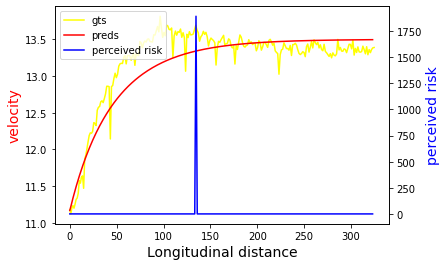

In [55]:
arr1 = np.array(vel_gts)
arr2 = np.array(vel_preds)
error_arr = arr1 - arr2
error_arr, mean_error_vel = computeYawError(vel_preds, vel_gts)
p_risks = np.array(p_risks)
#print(arr2)

print(mean_error_vel)

arr3 = np.array(position_gts_world)
#longitudinal distance
longi_dis = np.sqrt((arr3[:, 0] - arr3[0, 0])**2 + (arr3[:, 1] - arr3[0, 1])**2)

arr4 = np.array(position_preds_world)
longi_dis_ = np.sqrt((arr4[:, 0] - arr4[0, 0])**2 + (arr4[:, 1] - arr4[0, 1])**2)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(longi_dis, arr1, label = "gts", color="yellow")
#ax.plot(longi_dis[4:-4], smooth(arr1,9), label = "gts", color="red")
ax.plot(longi_dis_, arr2, label = "preds", color="red")
# set x-axis label
ax.set_xlabel("Longitudinal distance",fontsize=14)
# set y-axis label
ax.set_ylabel("velocity",color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(longi_dis_, p_risks, label = "perceived risk", color="blue")
ax2.set_ylabel("perceived risk",color="blue",fontsize=14)

# # mean and std of velocity error
# std = np.std(error_arr)
# ax2.axhline(mean_error_vel, color='k', linestyle='dashed', label='mean velocity error')
# ax2.axhline(mean_error_vel + std, color='y', linestyle='dashed', label='mean + σ')
# ax2.axhline(mean_error_vel - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='upper left')
# axes = plt.gca()
# axes.set_xlim([680, 690])
# axes.set_ylim([-2200, -2170])
# plt.legend()
plt.show()

fig.savefig('scene' + str(scene_index) + '_vel.png',
            format='png',
            dpi=100,
            bbox_inches='tight')


axis1: Velocity-longitudinal distance plot

axis2: Perceived risk-longitudinal distance plot

[0.         0.51493084 0.52030114 0.50501554 0.50823863 0.50789314
 0.5099744  0.50708595 0.49963697 0.49308162 0.47927466 0.4798164
 0.46636576 0.45194676 0.44981263 0.4314124  0.41630676 0.39603913
 0.35402443 0.33498543 0.30165775 0.28131709 0.25587046 0.22933714
 0.20887215 0.19628717 0.17314208 0.15189489 0.13310146 0.11635408
 0.10791117 0.10763097 0.11539831 0.12692252 0.13815696 0.16400766
 0.18479457 0.18053366 0.20324459 0.22016153 0.24588304 0.27025149
 0.28936275 0.31707949 0.34796404 0.3798097  0.41434063 0.44210601
 0.47466397 0.50929096 0.53509403 0.56806813 0.60344612 0.6381536
 0.6672839  0.70012389 0.73532273 0.7545401  0.7887965  0.81862044
 0.84700161 0.89375217 0.93714009 0.97291331 1.0139911  1.05731283
 1.09711788 1.13963476 1.18171928 1.21954461 1.25593056 1.29050454
 1.33434634 1.37690245 1.42455561 1.47695283 1.52134825 1.58592685
 1.63445189 1.66888198 1.70930534 1.74452734 1.79357664 1.84030361
 1.88168782 1.92226663 1.96420279 1.96351632 1.99352314 2.029952

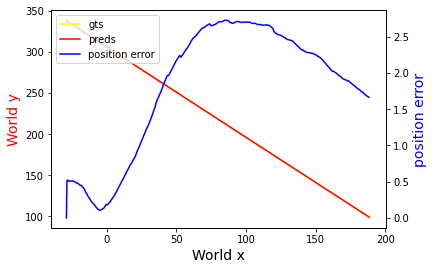

In [56]:
error_arr, mean_error_pos = computePosError(position_preds_world, position_gts_world)
print(mean_error_pos)

arr1 = np.array(position_gts_world)
arr2 = np.array(position_preds_world)

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(arr1[:, 0], arr1[:, 1], label = "gts", color="yellow")
ax.plot(arr2[:, 0], arr2[:, 1], label = "preds", color="red")
# set x-axis label
ax.set_xlabel("World x",fontsize=14)
# set y-axis label
ax.set_ylabel("World y",color="red",fontsize=14)
ax.legend()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(arr2[:, 0], error_arr, label = "position error", color="blue")
ax2.set_ylabel("position error",color="blue",fontsize=14)

# mean and std of position error
# mean = np.mean(error_arr)
# std = np.std(error_arr)
# ax2.axhline(mean, color='k', linestyle='dashed', label='mean position error')
# ax2.axhline(mean + std, color='y', linestyle='dashed', label='mean + σ')
# ax2.axhline(mean - std, color='y', linestyle='dashed', label='mean - σ')

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='upper left')

# axes = plt.gca()
# axes.set_xlim([680, 690])
# axes.set_ylim([-2200, -2170])
# plt.legend()
plt.show()

# save the plot as a file
fig.savefig('scene' + str(scene_index) + '_pos.png',
            format='png',
            dpi=100,
            bbox_inches='tight')